In [5]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score

In [6]:
# Load your data
df = pd.read_csv("./archive/nyt_6k.csv")  # Replace with your path

In [7]:
# Preprocess target
label_encoder = LabelEncoder()
df['section_encoded'] = label_encoder.fit_transform(df['section_name'])

In [8]:
# Preprocess text
def clean_text(text):
    import re
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'[^\w\s]', '', text)
    return text


In [9]:
df['abstract'] = df['abstract'].astype(str).apply(clean_text)

In [10]:
# Tokenization
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
tokens = tokenizer(
    df['abstract'].tolist(),
    padding='max_length',
    truncation=True,
    max_length=512,
    return_tensors='pt'
)

In [11]:
# Dataset Class
class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [12]:
# Create Dataset and DataLoader
labels = df['section_encoded'].tolist()
dataset = NewsDataset(tokens, labels)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [13]:
# Model Definition
class DistilBertClassifier(nn.Module):
    def __init__(self, num_classes):
        super(DistilBertClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        return self.classifier(pooled_output)

In [14]:
# Instantiate Model
num_classes = len(label_encoder.classes_)
model = DistilBertClassifier(num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DistilBertClassifier(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): L

In [15]:
# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

In [16]:
# Training Loop
EPOCHS = 3
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss {total_loss / len(dataloader):.4f}")

Epoch 1: Loss 2.1917
Epoch 2: Loss 1.3570
Epoch 3: Loss 0.9513


In [17]:
# Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].cpu().numpy()

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

In [18]:
print(f"\nAccuracy: {accuracy_score(all_labels, all_preds):.4f}")
print(f"Macro F1: {f1_score(all_labels, all_preds, average='macro'):.4f}")


Accuracy: 0.8548
Macro F1: 0.4338


In [19]:
# Predict function
def predict_section(text):
    model.eval()
    inputs = tokenizer(text, padding='max_length', truncation=True, max_length=512, return_tensors="pt")
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        predicted_class = torch.argmax(outputs, dim=1).item()
    return label_encoder.inverse_transform([predicted_class])[0]


In [20]:
# Example Prediction
sample_text = "The market is seeing strong growth in electric vehicles across Europe."
print("Predicted Section:", predict_section(sample_text))

Predicted Section: Business Day


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [2]:
# Load your NYT dataset
nyt_df = pd.read_csv("./archive/nyt_6k.csv")  # Change path as needed

C:\Users\yavis\AppData\Local\Temp\ipykernel_25716\3913903372.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=nyt_df["section_name"], order=nyt_df["section_name"].value_counts().index, palette="viridis")


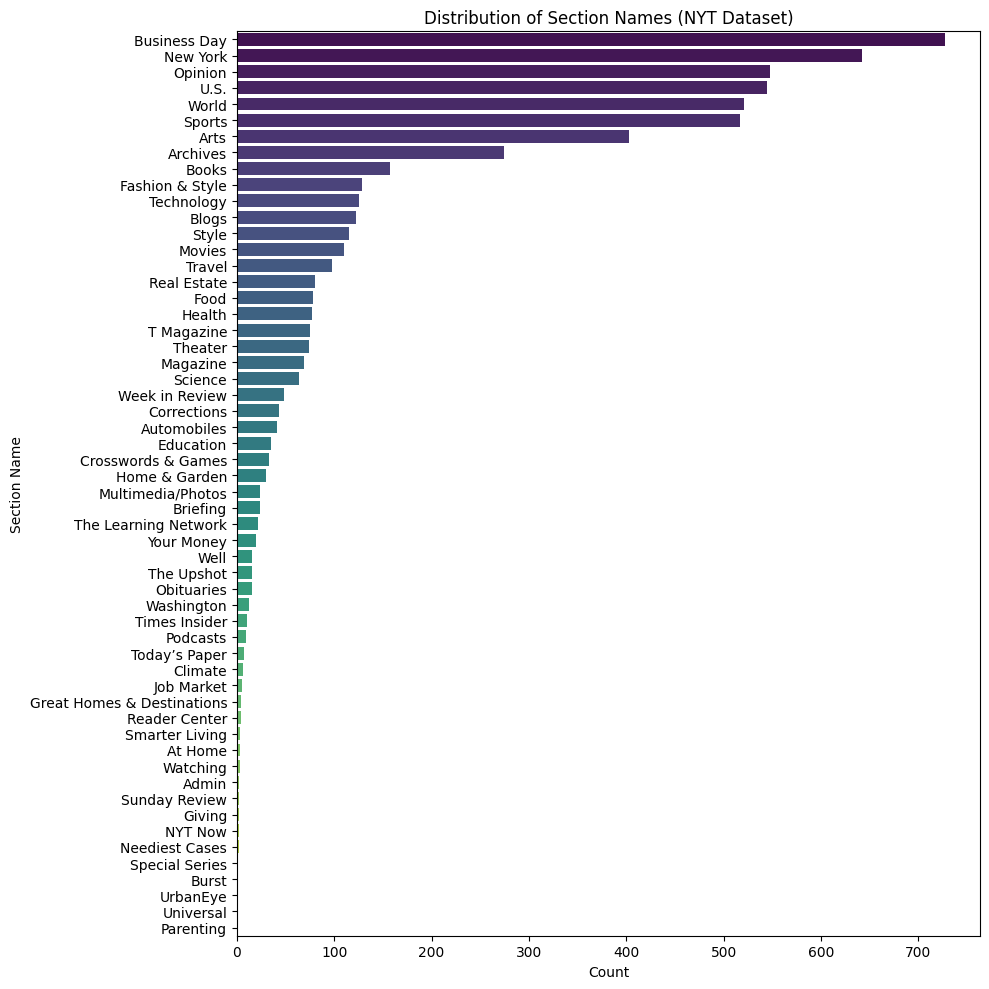

In [7]:
# Plot Section Name Distribution
plt.figure(figsize=(10, 10))
sns.countplot(y=nyt_df["section_name"], order=nyt_df["section_name"].value_counts().index, palette="viridis")
plt.title("Distribution of Section Names (NYT Dataset)")
plt.xlabel("Count")
plt.ylabel("Section Name")
plt.tight_layout()
plt.show()

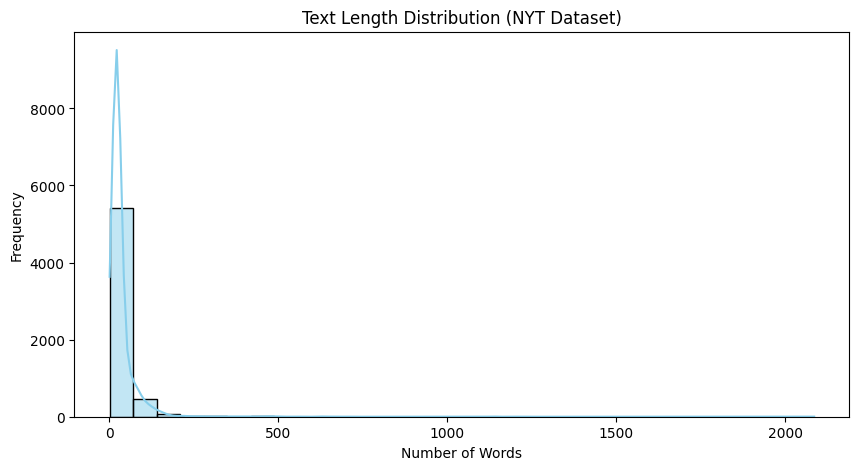

In [8]:
nyt_df["text_length"] = nyt_df["abstract"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 5))
sns.histplot(nyt_df["text_length"], bins=30, kde=True, color="skyblue")
plt.title("Text Length Distribution (NYT Dataset)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

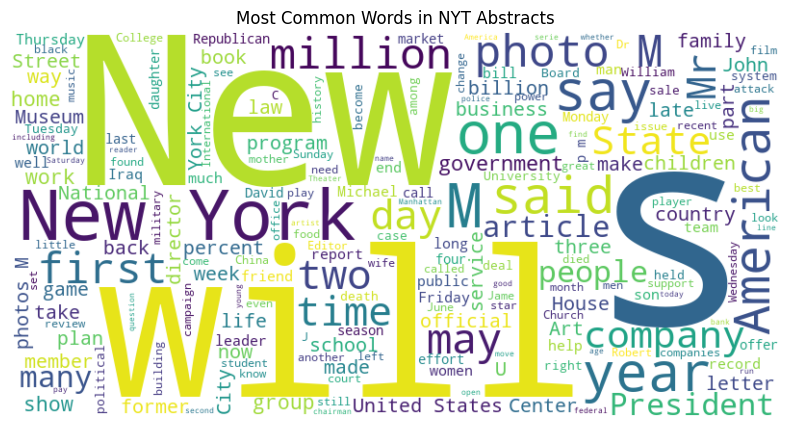

In [9]:
from wordcloud import WordCloud

# Combine all abstracts
text_data = " ".join(nyt_df["abstract"].dropna().tolist())

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in NYT Abstracts")
plt.show()
